# Review of Solving Linear Systems and Control Flow

Teng-Jui Lin

Content adapted from UW CHEME 375, Chemical Engineering Computer Skills, in Spring 2021.

- Python skills and numerical methods
  - Solving linear systems by [`scipy.linalg.solve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve.html)
- ChemE applications
  - Solving recycle streams
    - Linear system method
    - Tear stream method

## Solving recycle streams

**Problem Statement.** A system that consists a reactor and a separator with a recycle is shown below. The fresh feed is 1000 mol/h of pure A. The reaction is isomerization of A to B with a single pass conversion rate of 75%. The split fraction from steam 3 to 4 is 30%. Generate a stream table.

![Flow diagram](flow-diagram.png)

### Linear system method
**Solution.**

*Given values.* We are given the values

- fresh feed of A $F_1^A = 1000 \ \text{mol A/h}$
- fresh feed of B $F_1^B = 0 \ \text{mol B/h}$
- single pass conversion rate $X = 0.75$
- split fraction of A, B $f_{3-4} = 0.3$

*Degree of freedom analysis.* Adding all the degree of freedom analysis, the degree of freedom is

$$
\small
\begin{aligned}
& \text{8 total unknown variables} (F_2^A, F_2^B, F_3^A, F_3^B, F_4^A, F_4^B, F_5^A, F_5^B) \\
- & \text{2 mixing point material balance (A, B)} \\
- & \text{2 separator material balance (A, B)} \\
+ & \text{1 reactor reaction } (\mathrm{A \to B}) \\
- & \text{2 reactor reactive species (A, B)} \\
- & \text{0 reactor nonreactive species} \\
- & \text{3 other relation (conversion, split fraction of A, B)} \\
\hline & \text{0 degrees of freedom}\end{aligned}
$$

So the process variables can be uniquely determined.

*Mixing point balance*

$$
\begin{aligned}
&\text{A balance:} &F_1^A + F_4^A &= F_2^A \\
&\text{B balance:} &F_1^B + F_4^B &= F_2^B \\
\end{aligned}
$$

*Separator balance*

$$
\begin{aligned}
&\text{A balance:} &F_3^A = F_4^A + F_5^A \\
&\text{B balance:} &F_3^B = F_4^B + F_5^B \\
\end{aligned}
$$

*Reactor balance with single pass conversion rate*

$$
\begin{aligned}
&\text{A balance:} &F_3^A &= (1-X) F_2^A \\
&\text{B balance:} &F_3^B &= F_2^B + X F_2^A \\
\end{aligned}
$$

*Split fraction*

$$
\begin{aligned}
&\text{A balance:} &F_4^A &= f_{3-4}F_3^A \\
&\text{B balance:} &F_4^B &= f_{3-4}F_3^B \\
\end{aligned}
$$

*Establish linear system.* Write the variable terms on the left and known constant terms on the right:

$$
\begin{aligned}
\text{mixing point A balance:}& &F_2^A - F_4^A &= F_1^A \\
\text{mixing point B balance:}& &F_2^B - F_4^B &= F_1^B \\
\text{separator A balance:}& &F_4^A + F_5^A - F_3^A &= 0 \\
\text{separator B balance:}& &F_4^B + F_5^B - F_3^B &= 0 \\
\text{reactor A balance:}& &F_3^A - (1-X) F_2^A &= 0 \\
\text{reactor B balance:}& &F_3^B - F_2^B - X F_2^A &= 0 \\
\text{split fraction:}& &f_{3-4}F_3^A - F_4^A &= 0 \\
\text{split fraction:}& &f_{3-4}F_3^B - F_4^B &= 0 \\
\end{aligned}
$$

The the system of linear equations can be written in the form of

$$
\mathbf{Ax = b}
$$

where

$$
\mathbf{A} =
\begin{bmatrix}
1 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 & 1 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 & 0 & 1 & 0 & 1 \\
X-1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
X & -1 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & f_{3-4} & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & f_{3-4} & 0 & -1 & 0 & 0
\end{bmatrix},
\mathbf{x} =
\begin{bmatrix}
F_2^A \\ F_2^B \\ F_3^A \\ F_3^B \\ F_4^A \\ F_4^B \\ F_5^A \\ F_5^B \\
\end{bmatrix},
\mathbf{b} =
\begin{bmatrix}
F_1^A \\ F_1^B \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0
\end{bmatrix}
$$

We can then solve the system using `scipy.linalg.solve()`.

In [1]:
import numpy as np
from scipy.linalg import solve

In [2]:
# define process specifications
conv_a = 0.75
split_3_4_a = 0.2
F_1_a = 1000
F_1_b = 0

In [3]:
A = np.array([[1, 0, 0, 0, -1, 0, 0, 0],
              [0, 1, 0, 0, 0, -1, 0, 0],
              [0, 0, -1, 0, 1, 0, 1, 0],
              [0, 0, 0, -1, 0, 1, 0, 1],
              [conv_a-1, 0, 1, 0, 0, 0, 0, 0],
              [-conv_a, -1, 0, 1, 0, 0, 0, 0],
              [0, 0, split_3_4_a, 0, -1, 0, 0, 0],
              [0, 0, 0, split_3_4_a, 0, -1, 0, 0]])
b = np.array([F_1_a, F_1_b, 0, 0, 0, 0, 0, 0])

In [4]:
solve(A, b).reshape(-1, 2)

array([[1052.63157895,  197.36842105],
       [ 263.15789474,  986.84210526],
       [  52.63157895,  197.36842105],
       [ 210.52631579,  789.47368421]])

The solution is therefore

$$
\mathbf{x} =
\begin{bmatrix}
F_2^A \\ F_2^B \\ F_3^A \\ F_3^B \\ F_4^A \\ F_4^B \\ F_5^A \\ F_5^B \\
\end{bmatrix} =
\begin{bmatrix}
1053 \\ 197 \\ 263 \\ 987 \\ 53 \\ 197 \\ 211 \\ 789 \\
\end{bmatrix}
$$

We can now construct the stream table:

|Component|Steam 1|Steam 2|Steam 3|Steam 4|Steam 5|
|-:|-:|-:|-:|-:|-:|
|A [mol/h]|1000|1053|263|53|211|
|B [mol/h]|0|197|987|197|789|
|Total [mol/h]|1000|1250|1250|250|1000|

### Tear stream method

**Solution.** Tear stream method focuses on solving for the recycle stream. In this method, we view the recycle stream as two separate streams, steams 4a and 4b, with equal mass (and molar) flow rate:

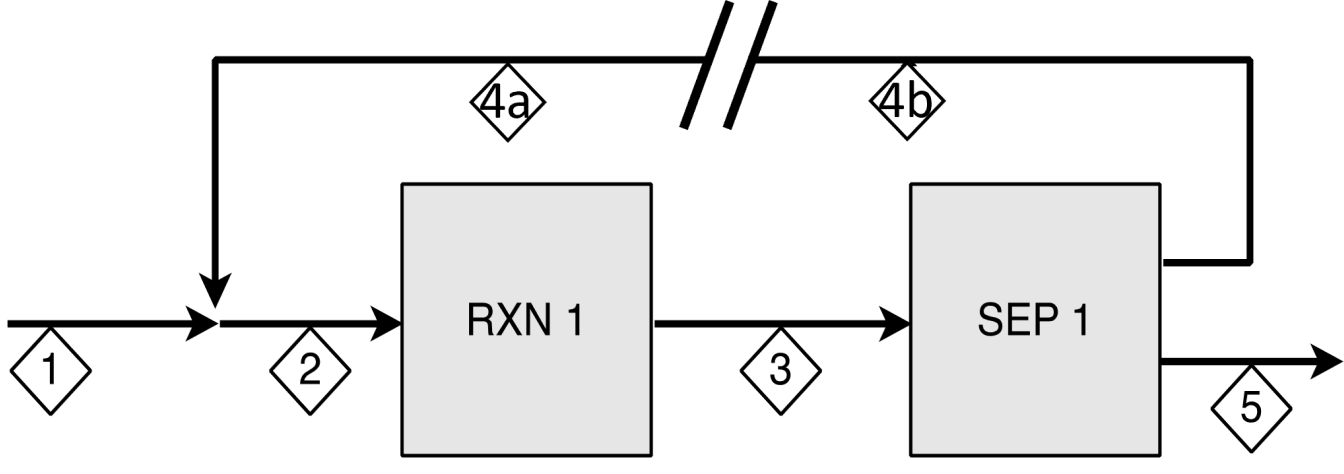

We first give an (arbitrary) guess to steam 4a, for example,

$$
\begin{aligned}
F_{4a}^A & = 0 \\
F_{4a}^B & = 0
\end{aligned}
$$

We then obtain the expression of the recycle stream 4b for A and B in terms of the guesses of steam 4a:

$$
\begin{aligned}
F_{4b}^A & = f_{3-4}(1-X)(F_1^A + F_{4a}^A) \\
F_{4b}^B & = f_{3-4}X(F_1^A + F_{4a}^A) + f_{3-4}(F_1^B + F_{4a}^B)
\end{aligned}
$$

We then use the result of stream 4b to update the guesses of steam 4a because they should be the same by our definition:

$$
\begin{aligned}
F_{4a}^A & = F_{4b}^A \\
F_{4a}^B & = F_{4b}^B
\end{aligned}
$$

After iterations, the result should converge so that there are not difference between stream 4a and 4b.

In [5]:
import numpy as np

In [6]:
# define process specifications
conv_a = 0.75
split_3_4_a = 0.2
F_1_a = 1000
F_1_b = 0

In [7]:
# define iteration parameters
tolerance = 1e-8
max_iter = 1000
i = 0

In [8]:
# define dummy values to enter loop
abs_error_4a_b = tolerance * 2
rel_error_4a_b = tolerance * 2

In [9]:
# define initial guesses of tear stream
F_4a_a_guess = 0
F_4a_b_guess = 0
F_4a_a = F_4a_a_guess
F_4a_b = F_4a_b_guess

In [10]:
# tear stream method logic
while (abs_error_4a_b > tolerance or rel_error_4a_b > tolerance) and i < max_iter:
    # calculate via material balance
    F_4b_a = split_3_4_a * (1 - conv_a) * (F_1_a + F_4a_a)
    F_4b_b = split_3_4_a * conv_a * (F_1_a + F_4a_a) + split_3_4_a * (F_1_b + F_4a_b)
    # calculate errors
    abs_error_4a_b = abs(F_4b_b - F_4a_b)
    rel_error_4a_b = abs_error_4a_b / F_4b_b
    # set next guess of 4a to current 4b
    F_4a_a = F_4b_a
    F_4a_b = F_4b_b
    i += 1

In [11]:
print(f'Iterations: {i}')
print(f'Absolute error: {abs_error_4a_b:.2e}')
print(f'Relative error: {rel_error_4a_b:.2e}')
print(f'A in recycle stream: {F_4a_a:.1f}')
print(f'B in recycle stream: {F_4a_b:.1f}')

Iterations: 16
Absolute error: 6.55e-09
Relative error: 3.32e-11
A in recycle stream: 52.6
B in recycle stream: 197.4


The stream table can then be calculated from other material balance relations with known flow rates of recycle stream.